# Множественный дисперсионный анализ

Проблемы множественного дисперсионного анализа заключаются в том, что при увеличении количества выборок для попарного сравнения их среднего, вероятноность найти различия хотя бы в одной паре начинает резко увеличиваться. Рассмотрим это на примере

In [25]:
import math
from scipy import stats
from scipy.stats import studentized_range
import numpy as np
import matplotlib as mpl
import pandas as pd
from pylab import rcParams
import itertools
import matplotlib.pyplot as plt

rcParams['figure.figsize'] = 10, 6
PATH = "/Users/daria/stepikcourse/"

In [23]:
anova_samp = stats.norm.rvs(loc=0, scale=1, size=10000) # генеральная совокупность 

In [10]:
def false_alarm(n, m, pval): # где - n - количество выборок, m - размер выборок, p - уровень значимости
    N = 1000 # количество экспериментов 
    result_dict = {'Yes': 0, 'No': 0}
    
    for i in range(0, N):
        matrix_select = [[random.choice(anova_samp) for i in range(0, m)] for j in range(0, n)]
        temp_list = []
        
        for first, second in itertools.combinations(matrix_select, 2):
            f, p = stats.f_oneway(first, second)
            if p < pval:
                temp_list.append(1)
            else:
                temp_list.append(0)
          
        if 1 in temp_list:
            result_dict['Yes'] += 1
            
        else: 
            result_dict['No'] += 1
    percent = result_dict['Yes']/N*100
    
    plt.bar(result_dict.keys(), result_dict.values(), color=['red', 'blue'])
    plt.title(f'Соотношение статистически значимых и не значимых различий {round(percent, 1)}%' )
    plt.ylabel('Количество экспериментов')


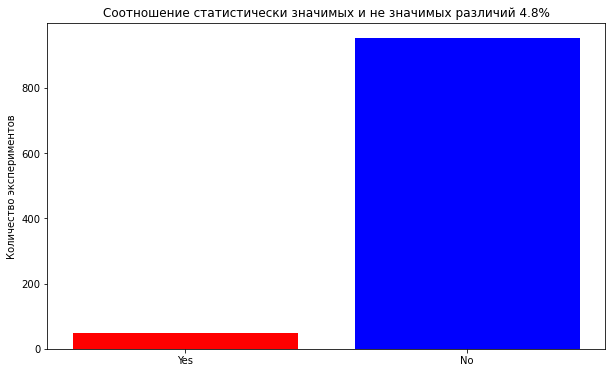

In [11]:
false_alarm(2, 30, 0.05)
# при 1000 кратном повторении эксперимента со сравнением только двух взятых выборок, количество статистически значимых результатов 
# приблизительно равно уровню зачимости 0.05

Однако, если количество сравнивыемых попарно выборок увеличить, картина резко изменится. 

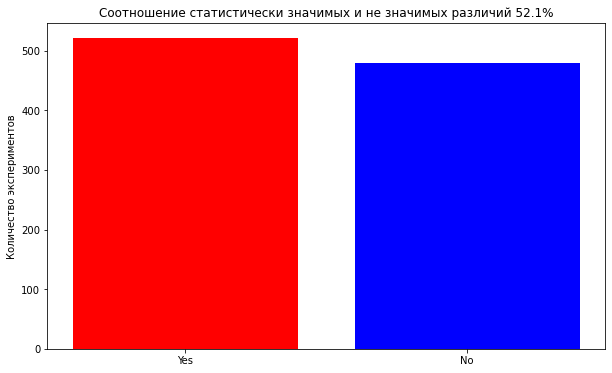

In [12]:
false_alarm(8, 30, 0.05)

Данных эффект называют "эффектом множественного сравнения", возникающего при необходимости построения семейства статистических выводов. Суть эффекта заключается в том, что когда некая популяция (ген. совокупность) начинается делится на малые группы увеличивается вероятность того, что найдется хотя бы выборка значимо отличающаяся от исходной популяция.
Для устранения этого эффекта существует несколько методов: \
\
Поправка Бонферрони \
Критерий Тьюки \

## Поправка Бонферрони


Поправка Бонферрони заключается в кратном уменьшение p уровня значимости в зависимости от количества выборок. Если выборок 10, то если мы хотим оставить вероятность совершения ошибки 1 рода на уровня 5%, мы делим 0,05 на количество попарных сравнений в одном эксперименте. 

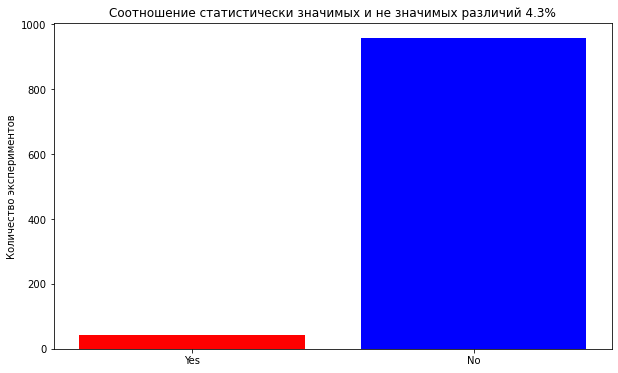

In [15]:
new_pvalue = 8 * (8 - 1) / 2
false_alarm(8, 30, 0.05/new_pvalue)

Однако, при дальнейшем увеличении количества выборок мощность метода значительно снижмается, p уровень значимости становится малым и мы рискуем пропустить статистическим значимые различие там, где они действительно есть т.е. совершить ошибку второго рода

## Критерий Тьюки


Критерий Тьюки используется для проверки нулевой гипотезы о равенстве средних
против альтернативной. Отличие данного критерия от t критерия Стьюдента заключается в ином расчете стандартной ошибки среднего:

Условия применения: \
Дисперси всех выборок были статистически неразличимы. \
Данные распределены нормально 

In [26]:
# вернемся к задаче о экспрессии генов
URL = PATH + 'genetherapy.csv'

data = pd.read_csv(URL)
terapy_kind = ['A', 'B', 'C', 'D']
expr = [list(data[data['Therapy'] == i]['expr']) for i in terapy_kind] # создадим массив списков с экспрессией гена
expr_dict = dict(zip(terapy_kind, expr)) # создадим словарь где ключ - название терапии

In [24]:
data.head()

,expr,Therapy
0,100,A
1,96,A
2,101,A
3,95,A
4,103,A


In [17]:
def tyukyutest(samples, pval):
    comb_first = [] # список комбинаций 
    comb_second = [] # список комбинаций
    temp_dict = samples # сохранение словаря в отдельную переменную
    keys = samples.keys() # список ключей 
    samples = list(samples.values()) # массив значений словаря
    ssw = 0 # sum of squares within
    q_list = [] # список критериев для сравниваемых пар
    pvalue_list = [] #  список pvalue 
    conf_interval_up = [] # верхний доверительный интервал
    conf_interval_down = [] # нижний доверительный интервал
    n = 0 # общее количество элементов во всех 4 выборках
    
    for i in range(len(samples)):
        
        for j in samples[i]:
            ssw = ssw + (j - np.mean(samples[i])) ** 2
        n = n + len(samples[i])
        
    dfssw = n - len(samples)       
    msw = ssw / dfssw 
    se = (msw / 15) ** (0.5)
    q_crit = studentized_range.ppf(1-pval, len(samples), dfssw)
    
    for firts, second in itertools.combinations(samples, 2):
        
        for key in temp_dict.keys():
            if temp_dict[key] == firts:
                comb_first.append(key)
            elif temp_dict[key] == second:
                comb_second.append(key)
                
        q = (np.mean(firts) - np.mean(second)) / se
        q_list.append(q)
        pvalue = 1 - studentized_range.cdf(q, len(samples), dfssw)
        pvalue_list.append(pvalue)
        conf_interval_up.append((np.mean(firts) - np.mean(second)) + q_crit * se)
        conf_interval_down.append((np.mean(firts) - np.mean(second)) - q_crit * se)
        
    combinations = [f'{i}-{j}' for i, j in zip(comb_first, comb_second)]
        
    return q_list, pvalue_list, conf_interval_up, conf_interval_down, combinations

In [20]:
columns = ['q', 'pvalue', 'conf_interval_up', 'conf_interval_down', 'combinations'] # зададим список колонок
dna_tyukitest = pd.DataFrame(tyukyutest(expr_dict, 0.05)).T # создадим транспорированный датафрайм
dna_tyukitest.columns = columns # присвоим новые названия колонок
dna_tyukitest.set_index('combinations', inplace=True) # зададим столбец combinations в качестве индекса

In [21]:
dna_tyukitest

,q,pvalue,conf_interval_up,conf_interval_down
combinations,,,,
A-B,0.749595,0.95142,5.595897,-3.729231
A-C,4.283398,0.018886,9.995897,0.670769
A-D,5.943214,0.000542,12.062564,2.737436
B-C,3.533803,0.071041,9.062564,-0.262564
B-D,5.19362,0.002944,11.129231,1.804103
C-D,1.659817,0.645794,6.729231,-2.595897


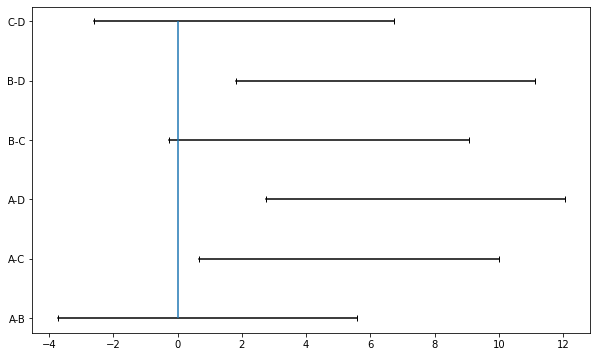

In [22]:
x1 = list(dna_tyukitest['conf_interval_up'])
x2 = list(dna_tyukitest['conf_interval_down'])
y = list(dna_tyukitest.index)

for x1, x2, y in zip(x1, x2, y):
    plt.plot((x1, x2), (y, y), '|-', color='black') # построим доверительные интервалы
plt.vlines(0, 0, 5)

Разница средних пар B-D, A-D, A-C не включает 0, выборки имеют статистические значимые различия, что дает нам основания отклонить Н0 о равенстве этих средних